# ECBM4040: Assignment 1, Task 1 - Basic ML Classifiers

In this task, you are going to implement two classifers and apply them to the  CIFAR-10 dataset: 

(1) Linear SVM classifier, and

(2) Softmax classifier.

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load CIFAR-10 data

CIFAR-10 is a widely used dataset which contains 60,000 color images of size 32x32 divided into 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Here you are going to use a small part (~500) of data (images) for classification.

See https://www.cs.toronto.edu/~kriz/cifar.html. 

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# We have vectorized the data (rearranged the storage of images) for you. 
# That is, we flattened 32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 colors.
# The reason we do this is because we can not put 3-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML model). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [3]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 samples from the train set: indices 1~49,000
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
Development data shape: (100, 3072)
Development data shape (100,)


In [4]:
# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (100, 3073)


## Part 1: Linear Support Vector Machine (SVM) Classifier

In this part, you are going to implement a linear SVM classifier. 

Excellent summaries of SVM methods are presented in ([John Paisley, "Machine Learning for Data Science," SVM_slides](http://www.columbia.edu/~jwp2128/Teaching/W4721/Spring2017/slides/lecture_2-23-17.pdf)) and ([David Sontag, "Introduction to Machine Learning,", New York University, Lectures 4,5,6 ](http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture4.pdf)).

<span style="color:red"><strong>TODO</strong></span>: The code is given in **./ecbm4040/classifiers/linear_svm.py**, where a naive linear SVM is provided. You need to understand the algorithm and implement a linear SVM using fully vectorized operations with numpy. When you finish the code, run the block below - it will help you verify your result. The loss error should be around 1e-14, while the gradient error should be below 1e-11. Moreover, the vectorized SVM should be much faster than the naive SVM.

**Brief introduction to SVM**

Support Vector Mahcine(SVM) is a very important supervised classification model developed in 1992. ([Original paper by Boser et al.](http://dl.acm.org/citation.cfm?id=130401)). It can be used not only for binary classification problems, but also for multiclass classification. As our course reference books points out:
> One key innovation associated with support vector machines is the _kernel tricks_.

SVM is a __max margin classifier__ that tries to maximize the __margin__ between clusters of data points. The __margin__ between a boundary hyperplane and a cluster is defined as the minimal distance from the points inside the cluster to the boundary. Intuitively speaking, the classification boundary should be as far away from any cluster as possible. 

![classifier_graph](./img/SVM1.png)

The picture above shows what a SVM boundary could look like, in a 2-D plane. Notice that in the left image, the boundary is good enough to distinguish the 2 clusters, but the margins are small (at least one point from a cluster is very close to the boundary). In the image on the right, the boundary separates the 2 clusters, and it is also far from each of the clusters - this is a good SVM boundary. (Image source: Prof. John Paisley, ([_Machine Learning for Data Science_](http://www.columbia.edu/~jwp2128/Teaching/W4721/Spring2017/W4721Spring2017.html)), Columbia University, spring 2017. 




**Here we discuss the multi-class linear SVM**

The prediction model of a linear SVM is:

$$\mathbf{y}_{prediction} = argmax(\mathbf{x}\times \mathbf{W} + \mathbf{b})$$

The $argmax$ function outputs the index of the maximum element for each $x_i$.

To train this SVM model, we usually consider the following optimization problem:

$$\min_{\mathbf{W}} \frac{1}{2}||\mathbf{W}||^2 $$
<!-- ## $$\min_{W} \quad \frac{1}{2}||W||^2$$ -->

such that $$\quad \mathbf{x}_i \times \mathbf{W}_{\mathbf{y}_i}-\mathbf{x}_i \times \mathbf{W}_c\geq \delta,\quad for \ i=1,...N, \quad c=1,...,C,$$

<!-- $$such \quad that \quad \mathbf{x_i \times W_{y_i}-x_i \times W_c\geq \delta},\quad for \ i=1,...N, \quad c=1,...,C$$  -->

where $N$ is the total number of training samples while $C$ is the number of classes.

Here we do not consider the bias term because we have already expanded the bias dimension with all ones in input $\mathbf{x}$. The value of $\delta$ indicates the width of the margin (there are no training points within the width of the margin, from any cluster). To make a more restricted classification, we could choose a larger $\delta$. However, for a more robust classification (sometimes raw data contains a lot of noise, and the separable plane cannot be found), $\delta$ can have a negative value. In that case, we need to add a penalty term wrt $\delta$ into the objective function. Here the default $\delta$ is 1.

To solve the problem above, one needs to convert it into its Lagrangian dual form. We do not cover the details here. The final loss function is:

$$L=\alpha\times \frac{1}{2}\times||\mathbf{W}||^2+\sum_i\sum_c \max(0,\delta + \mathbf{x}_i \times \mathbf{W}_c - \mathbf{x}_i \times \mathbf{W}_{y_i})$$

To determine the bondary hyperplane, we need to compute $\mathbf{W}$, which will be obtained by minimizing $L$ over all trainable variables. The $\alpha$ is a hyperparameter which we set for penalizing the l2-norm.

In [5]:
from ecbm4040.classifiers.linear_svm import svm_loss_naive
from ecbm4040.classifiers.linear_svm import svm_loss_vectorized

# generate a random SVM weight matrix seeded with small numbers
np.random.seed(2321)
W = np.random.randn(3073, 10) * 0.0001 

# naive numpy implementation of SVM
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

# vectorized numpy implementation of SVM
tic = time.time()
loss_vec, grad_vec = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

# check the correctness
print('*'*100)
print('Relative loss error is {}'.format(abs(loss_vec-loss_naive)))
grad_err = np.linalg.norm(grad_naive - grad_vec, ord='fro')
print('Relative gradient error is {}'.format(grad_err))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_naive, loss_vec)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_naive, grad_vec)))

naive numpy loss: 8.371341814052801, takes 0.08096647262573242 seconds.
vectorized numpy loss: 8.37134181405281, takes 0.0031511783599853516 seconds.
****************************************************************************************************
Relative loss error is 8.881784197001252e-15
Relative gradient error is 7.089893523416434e-12
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax classifier

Softmax function is a normalized exponential function. Suppose the input is a $K$-dimensional vector $\mathbf{z}$. The softmax function is given by

$$\sigma({\rm \mathbf{z}})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}, for\  j=1,...,K.$$

In probability theory, softmax can be explained as a categorical distribution, and that is why it is always used in multiclass classification problem. Hence, this is an important function and you will usually use it in the future deep learning experiments. Here you are going to implement a basic softmax layer. Suppose the input $\mathbf{X}$ with shape $N \times D$ and a corresponding label vector $\mathbf{y}$ with length $N$, where $N$ is the number of samples and $D$ is the number of features. The loss of the softmax output is given by

$$loss = \sum_{i=1}^N -{\rm log}\left( softmax(\mathbf{W} \times X_i)_{y_i} \right)$$

In most cases, you also need to consider a bias term $b$ with length D. However, in this experiment, since a bias dimension has been added into the $X$, you can ignore it. 

<span style="color:red"><strong>TODO</strong></span>: Finish the code in **./ecbm4040/classifiers/softmax.py** and you should implement a softmax layer in three ways. For the first two implementations, we provide the check code for you to verify your code. 

* Naive method using for-loop
* Vectorized method
* Softmax in Tensorflow. This step will familiarize you with tensorflow functions. You can refer to the check code.

Do not forget the $L2$ regularization term in the loss.

In [6]:
from ecbm4040.classifiers.softmax import softmax_loss_naive
from ecbm4040.classifiers.softmax import softmax_loss_vectorized

# generate a random SVM weight matrix of small numbers
np.random.seed(2321)
W = np.random.randn(3073, 10) * 0.0001 

# ground truth of loss and gradient
W_tf = tf.placeholder(tf.float32, shape=(3073,10))
X = tf.placeholder(tf.float32, shape=(None, 3073))
y = tf.placeholder(tf.int32, shape=(None,))
reg = tf.constant(0.000005)
init_op = tf.global_variables_initializer()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,10))
loss0 = tf.reduce_mean(cross_entropy) + reg*tf.reduce_sum(W_tf*W_tf)
grad0 = tf.gradients(loss0, W_tf)
out0 = (loss0, grad0)
with tf.Session() as sess:
    sess.run(init_op)
    tic = time.time()
    loss_gt, grad_gt = sess.run(out0, feed_dict={W_tf: W, X: X_dev, y: y_dev})
    toc = time.time()

# naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

# vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

# Verify your result here - use 'rel_err' for error evaluation.
def rel_err(a,b):
    return np.mean(abs(a-b))

print('*'*100)
print('Relative loss error of naive softmax is {}'.format(rel_err(loss_gt,loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(rel_err(loss_gt,loss_vec)))
print('Gradient error of naive softmax is {}'.format(rel_err(grad_gt,grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(rel_err(grad_gt,grad_vec)))

naive numpy loss: 2.2917831825676753, takes 0.05586838722229004 seconds.
vectorized numpy loss: 2.291783182567676, takes 0.003998994827270508 seconds.
****************************************************************************************************
Relative loss error of naive softmax is 1.5025703170579163e-07
Relative loss error of vectorized softmax is 1.502570308176132e-07
Gradient error of naive softmax is 2.662355581942842e-07
Gradient error of vectorized softmax is 2.662355581792371e-07


In [7]:
# softmax in tensorflow
W_tf = tf.placeholder(tf.float32, shape=(3073,10))
X = tf.placeholder(tf.float32, shape=(None, 3073))
y = tf.placeholder(tf.int32, shape=(None,))
reg = tf.constant(0.000005)
init_op = tf.global_variables_initializer()

# Understand how to use this function "tf.nn.softmax_cross_entropy_with_logits".
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,10))
loss_tf = tf.reduce_mean(cross_entropy) + reg*tf.reduce_sum(W_tf*W_tf)
grad_tf = tf.gradients(loss_tf, W_tf)
out = (loss_tf, grad_tf)
with tf.Session() as sess:
    sess.run(init_op)
    tic = time.time()
    loss, grad = sess.run(out, feed_dict={W_tf: W, X: X_dev, y: y_dev})
    toc = time.time()
    
print("loss output of tensorflow softmax is {}".format(loss))

loss output of tensorflow softmax is 2.291783332824707


## Part 3: Train your classifiers

Now you can start to train your classifiers. We are going to use gradient descent algorithm for training, which is differs from a usual SVM training process. 

<span style="color:red"><strong>TODO</strong></span>: The original code is given in **./ecbm4040/classifiers/svm_classifier.py**. You need to finish **train** and **predict** functions in the class **SVMClassifier**. Later, you use its subclasses **LinearSVM** and **Softmax** to train the model seperately and verify your result.

In the training section, you are asked to implement two optimization methods, (a)Stochastic gradient descent (SGD), and (b)SGD with momentum. Pseudo code for SGD is shown below.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```

### Train Linear SVM + SGD

In [8]:
from ecbm4040.classifiers.basic_classifiers import LinearSVM

# Linear SVM + SGD
classifier = LinearSVM()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the LinearSVM.predict function and evaluate the performance on both the
# training set and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 24.924832
iteration 100 / 1500: loss 13.034978
iteration 200 / 1500: loss 9.675829
iteration 300 / 1500: loss 9.138077
iteration 400 / 1500: loss 8.507585
iteration 500 / 1500: loss 8.353283
iteration 600 / 1500: loss 7.283507
iteration 700 / 1500: loss 6.881759
iteration 800 / 1500: loss 6.971925
iteration 900 / 1500: loss 7.425159
iteration 1000 / 1500: loss 7.573132
iteration 1100 / 1500: loss 6.847143
iteration 1200 / 1500: loss 7.614177
iteration 1300 / 1500: loss 7.499665
iteration 1400 / 1500: loss 6.988794
training accuracy: 0.307122
validation accuracy: 0.306000


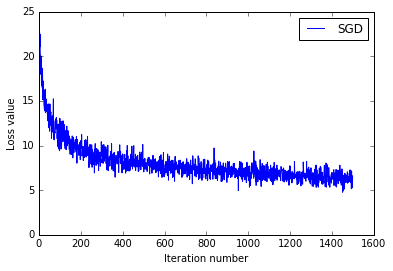

In [9]:
# SGD Error Plot (loss curve)
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

In [10]:
from ecbm4040.classifiers.basic_classifiers import Softmax

# Linear SVM + SGD
classifier = Softmax()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 5.738401
iteration 100 / 1500: loss 4.079561
iteration 200 / 1500: loss 3.319322
iteration 300 / 1500: loss 3.418094
iteration 400 / 1500: loss 3.185188
iteration 500 / 1500: loss 2.824187
iteration 600 / 1500: loss 2.888702
iteration 700 / 1500: loss 3.095239
iteration 800 / 1500: loss 2.877236
iteration 900 / 1500: loss 3.062180
iteration 1000 / 1500: loss 2.711101
iteration 1100 / 1500: loss 2.649729
iteration 1200 / 1500: loss 2.678421
iteration 1300 / 1500: loss 2.603608
iteration 1400 / 1500: loss 2.598300
training accuracy: 0.246388
validation accuracy: 0.223000


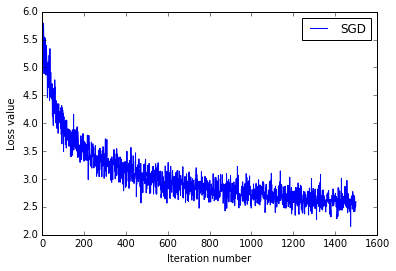

In [11]:
# SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()